<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/Candlestick_Plotting_Function.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mplfinance -q
!pip install ccxt -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## HISTORICAL

--- Running Live Candlestick Plot Generator ---
📡 Fetching live data for BTC/USD...
📈 Generating candlestick chart for BTC/USD (720 periods) using Matplotlib...


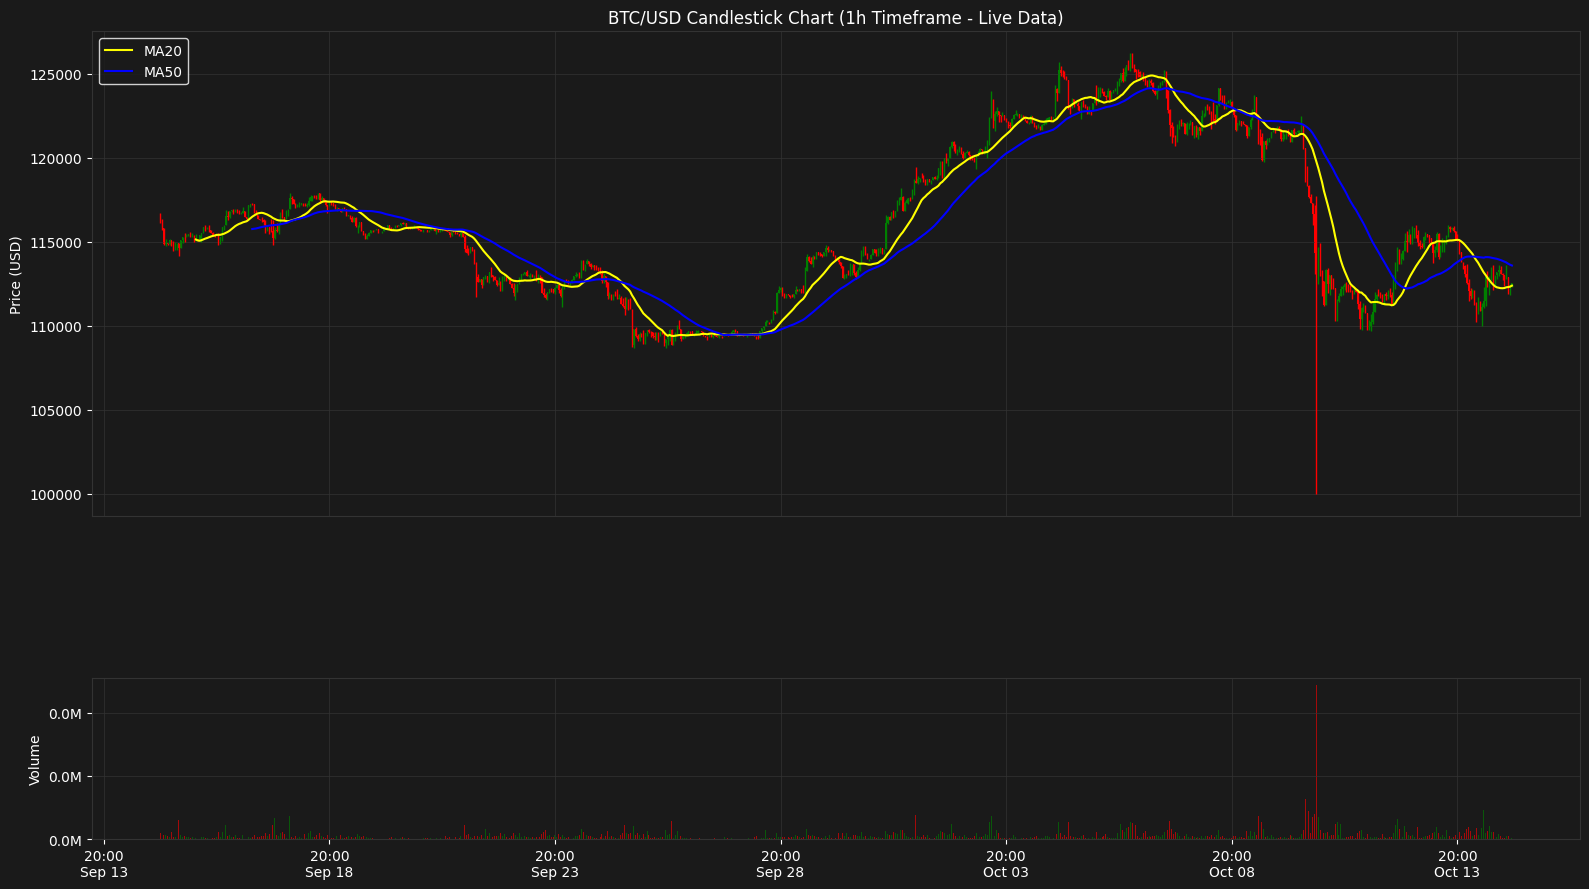

📡 Fetching live data for ETH/USD...
📈 Generating candlestick chart for ETH/USD (720 periods) using Matplotlib...


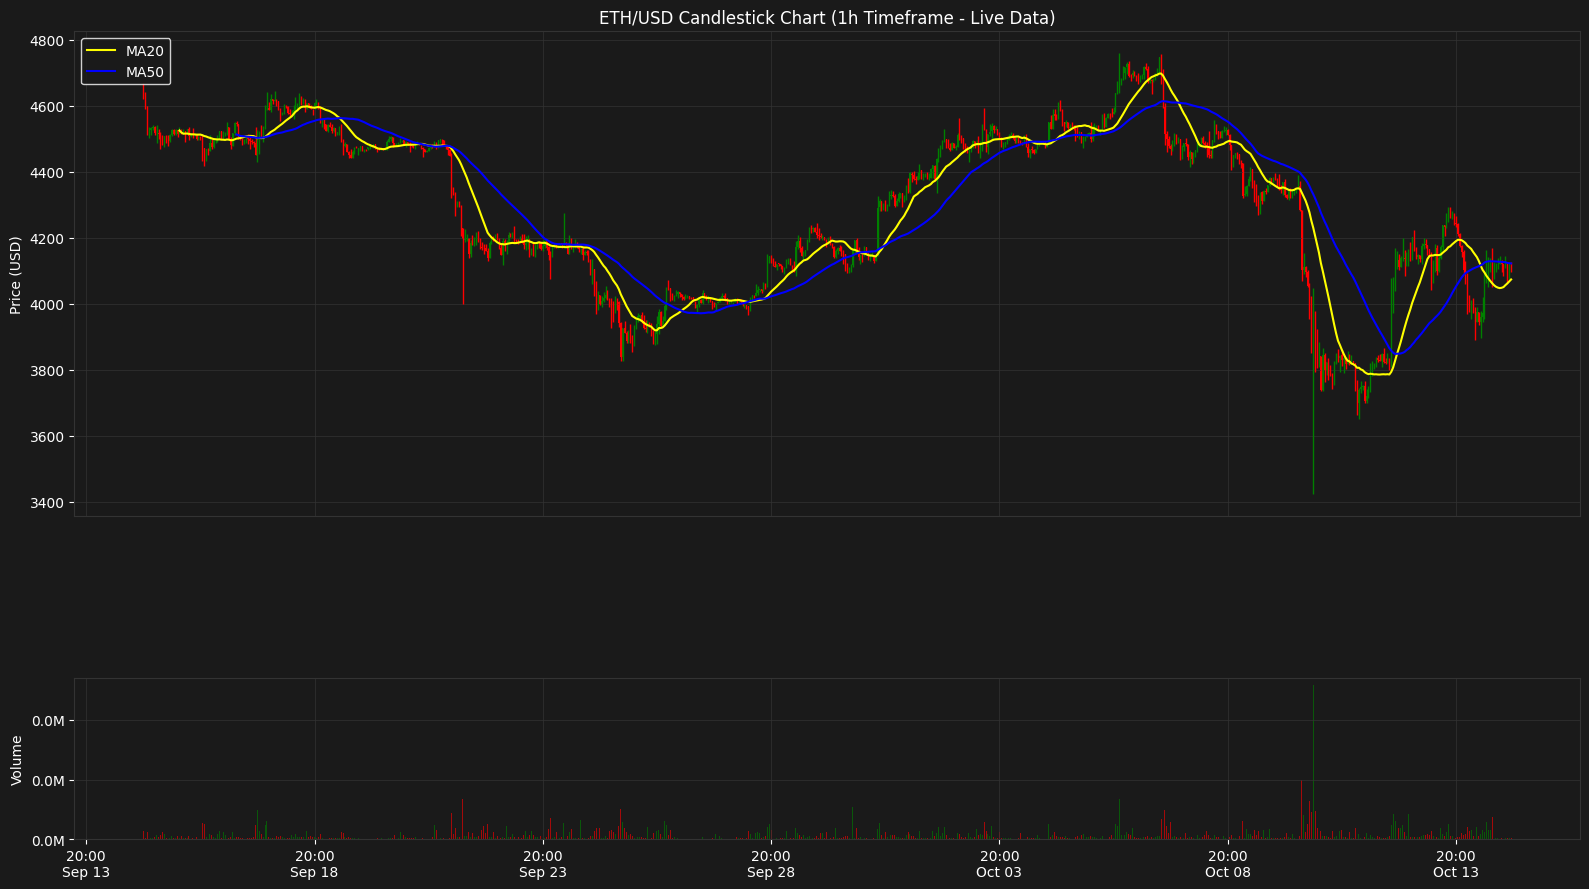

📡 Fetching live data for SOL/USD...
📈 Generating candlestick chart for SOL/USD (720 periods) using Matplotlib...


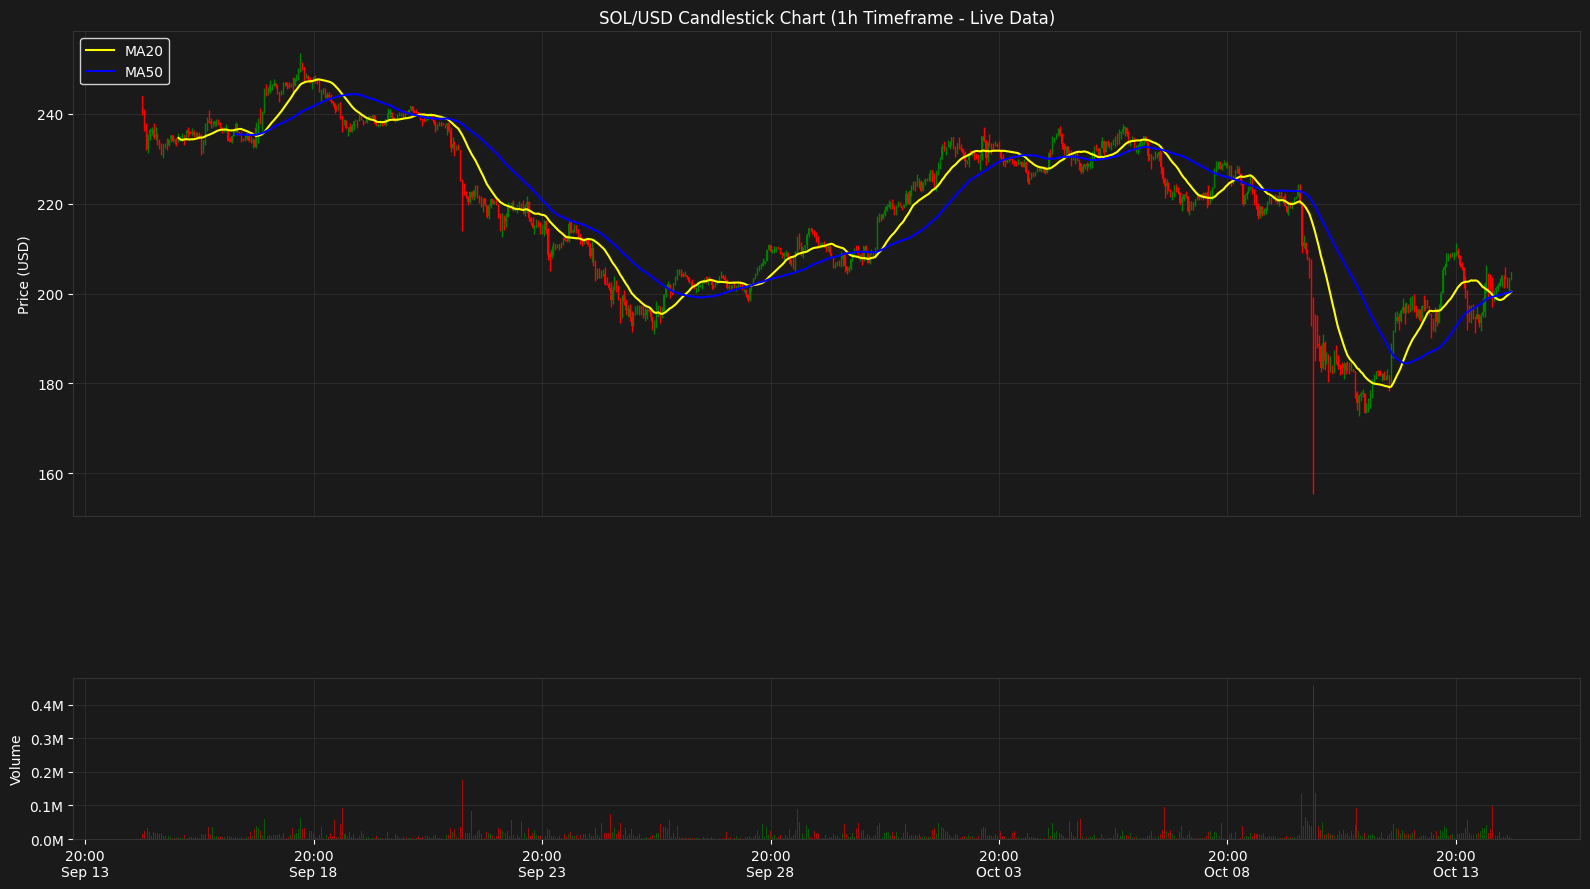

In [11]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pytz
import datetime as dt
from google.colab import userdata

# --- CONFIGURATION & INITIALIZATION ---
# These variables rely on your bot's setup to be defined or loaded.
# We fetch them securely using userdata and assume they match your bot's environment.
try:
    KRAKEN_API_KEY = userdata.get('KRAKENDANKA')
    KRAKEN_SECRET = userdata.get('KRAKENDANKASECRET')
except:
    # Use dummy keys if not found, but live fetching will likely fail without them
    KRAKEN_API_KEY = ''
    KRAKEN_SECRET = ''

# The bot already uses this Timezone
TIMEZONE = pytz.timezone('America/New_York')
LOOKBACK_WINDOW_SIZE = 720
TIMEFRAME = '1h'

# Initialize Exchange Client
exchange = ccxt.kraken({
    'apiKey': KRAKEN_API_KEY,
    'secret': KRAKEN_SECRET,
    'enableRateLimit': True
})

def get_historical_data_for_plot(symbol, lookback_candles=LOOKBACK_WINDOW_SIZE):
    """Fetches real-time OHLCV data using CCXT."""
    try:
        print(f"📡 Fetching live data for {symbol}...")
        ohlcv = exchange.fetch_ohlcv(symbol, TIMEFRAME, limit=lookback_candles)

        if not ohlcv:
            print(f"❌ No live data found for {symbol}.")
            return None

        df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

        # Prepare DataFrame: convert timestamp to datetime index
        df['Date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize(pytz.utc).dt.tz_convert(TIMEZONE)
        df.set_index('Date', inplace=True)

        # Calculate MAs for context (20-period and 50-period, based on bot logic)
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean()

        return df.drop(columns=['timestamp'])

    except Exception as e:
        print(f"❌ CCXT data fetch error for {symbol}: {e}")
        return None

def plot_candles_with_indicators(symbol='BTC/USD'):
    """
    Generates a candlestick plot for the specified symbol with MAs and Volume using pure Matplotlib.

    Args:
        symbol (str): The cryptocurrency pair to plot (e.g., 'BTC/USD', 'ETH/USD').
    """
    df_plot = get_historical_data_for_plot(symbol)

    if df_plot is None:
        return

    print(f"📈 Generating candlestick chart for {symbol} ({len(df_plot)} periods) using Matplotlib...")

    # 1. Setup Figure and Axes
    fig = plt.figure(figsize=(16, 9), facecolor='#1a1a1a')

    # Define gridspec: 3 parts for price/MAs, 1 part for Volume
    gs = fig.add_gridspec(3, 1, hspace=0, height_ratios=[3, 1, 1])
    ax_price = fig.add_subplot(gs[0])
    ax_volume = fig.add_subplot(gs[2], sharex=ax_price)

    # Dark Theme Configuration
    for ax in [ax_price, ax_volume]:
        ax.set_facecolor('#1a1a1a')
        ax.tick_params(axis='both', colors='white')
        ax.spines['bottom'].set_color('#333333')
        ax.spines['top'].set_color('#333333')
        ax.spines['right'].set_color('#333333')
        ax.spines['left'].set_color('#333333')
        ax.grid(True, color='#333333', linestyle='-', linewidth=0.5)

    # 2. Candlestick Plotting (Manual)

    # Convert dates to matplotlib format
    dates = df_plot.index.map(mdates.date2num)

    # Colors for Up/Down candles
    def get_candle_colors(df):
        return ['green' if close >= open_price else 'red' for open_price, close in zip(df['Open'], df['Close'])]

    colors = get_candle_colors(df_plot)

    # Plotting Wicks (Low to High)
    ax_price.vlines(dates, df_plot['Low'], df_plot['High'], color=colors, linewidth=1)
    # Plotting Bodies (Open to Close)
    bar_width = 0.02 # Width of the candle body
    ax_price.bar(dates, df_plot['Close'] - df_plot['Open'], bar_width, bottom=df_plot['Open'], color=colors)

    # 3. Plot Moving Averages
    ax_price.plot(dates, df_plot['MA20'], color='yellow', label='MA20', linewidth=1.5)
    ax_price.plot(dates, df_plot['MA50'], color='blue', label='MA50', linewidth=1.5)

    # 4. Volume Plotting
    volume_colors = get_candle_colors(df_plot) # Use same color logic for volume bars
    ax_volume.bar(dates, df_plot['Volume'], bar_width, color=volume_colors, alpha=0.6)
    ax_volume.set_ylabel('Volume', color='white')
    ax_volume.tick_params(axis='y', labelcolor='white')
    # Format volume to Millions
    ax_volume.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

    # 5. Final Formatting and Labels
    ax_price.set_title(f'{symbol} Candlestick Chart ({TIMEFRAME} Timeframe - Live Data)', color='white')
    ax_price.set_ylabel('Price (USD)', color='white')
    ax_price.legend(loc='upper left', frameon=True, facecolor='#1a1a1a', edgecolor='white', labelcolor='white')

    # Date formatting for x-axis
    ax_volume.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %d', tz=TIMEZONE))

    # Hide x-ticks on price chart to align plots perfectly
    ax_price.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.setp(ax_price.get_xticklabels(), visible=False)

    plt.tight_layout()
    plt.show()

# Example usage function
def run_plot_examples():
    """Function to run plotting for all three symbols."""
    print("--- Running Live Candlestick Plot Generator ---")
    plot_candles_with_indicators('BTC/USD')
    plot_candles_with_indicators('ETH/USD')
    plot_candles_with_indicators('SOL/USD')

# When run directly, execute the plotting examples
if __name__ == '__main__':
    run_plot_examples()


## 15M TIMEFRAME

--- Running Live Candlestick Plot Generator ---
📡 Fetching live data for BTC/USD at 15m resolution...
📈 Generating candlestick chart for BTC/USD (200 periods) using Matplotlib...


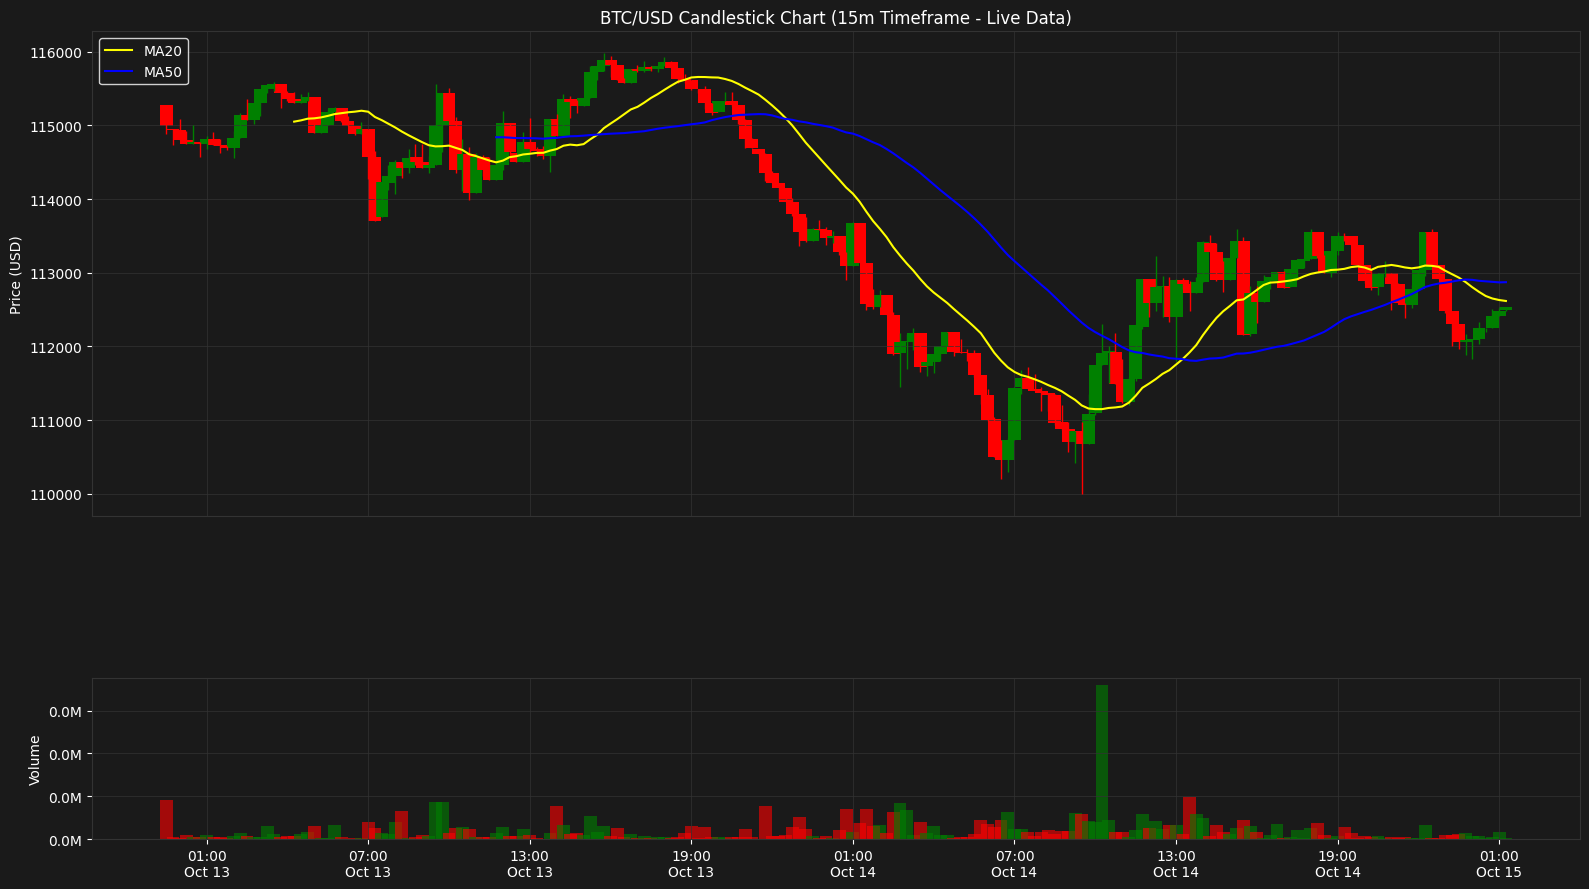

📡 Fetching live data for ETH/USD at 15m resolution...
📈 Generating candlestick chart for ETH/USD (200 periods) using Matplotlib...


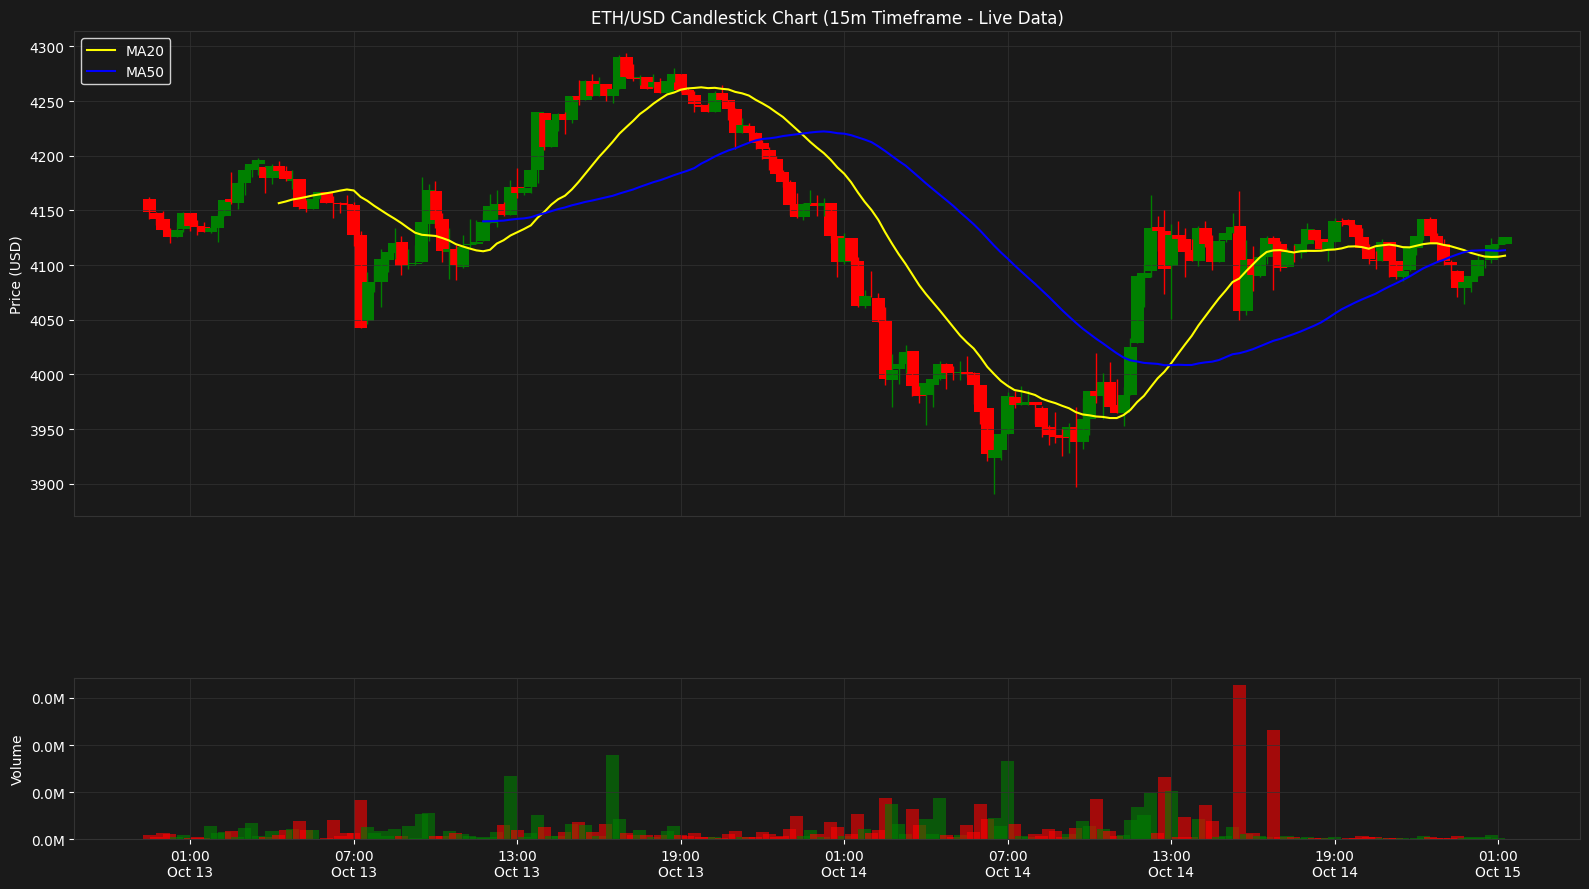

📡 Fetching live data for SOL/USD at 15m resolution...
📈 Generating candlestick chart for SOL/USD (200 periods) using Matplotlib...


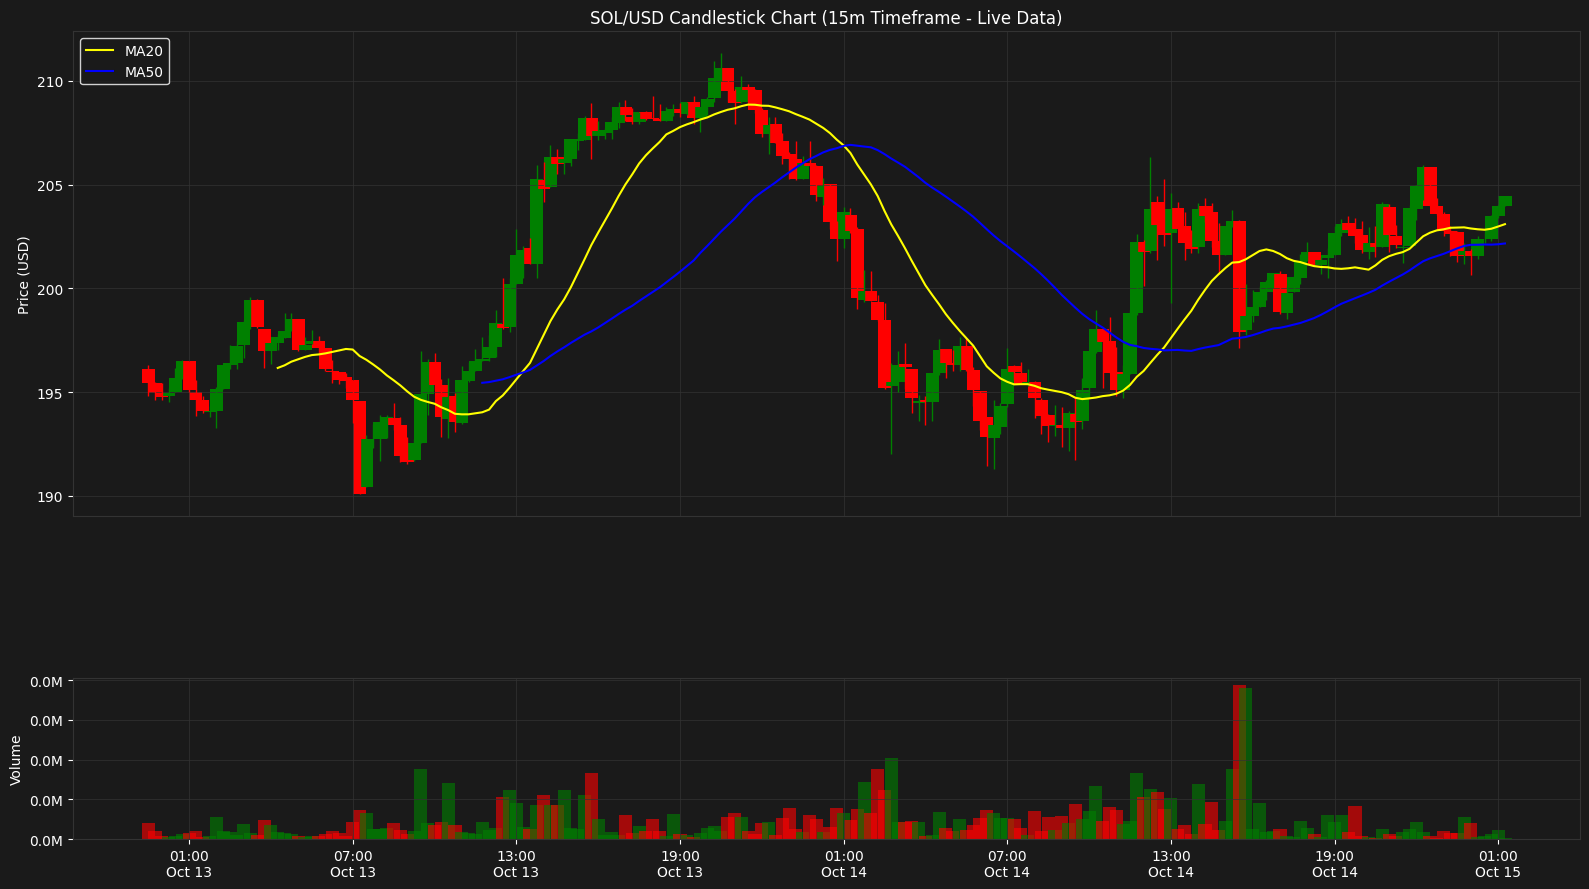

In [9]:
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import pytz
import datetime as dt
from google.colab import userdata

# --- CONFIGURATION & INITIALIZATION ---
# These variables rely on your bot's setup to be defined or loaded.
# We fetch them securely using userdata and assume they match your bot's environment.
try:
    KRAKEN_API_KEY = userdata.get('KRAKENDANKA')
    KRAKEN_SECRET = userdata.get('KRAKENDANKASECRET')
except:
    # Use dummy keys if not found, but live fetching will likely fail without them
    KRAKEN_API_KEY = ''
    KRAKEN_SECRET = ''

# The bot already uses this Timezone
TIMEZONE = pytz.timezone('America/New_York')

# --- MODIFIED FOR HIGHER RESOLUTION ---
LOOKBACK_WINDOW_SIZE = 200  # Only fetch the last 200 candles
TIMEFRAME = '15m'          # Use 15-minute candles for finer detail

# Initialize Exchange Client
exchange = ccxt.kraken({
    'apiKey': KRAKEN_API_KEY,
    'secret': KRAKEN_SECRET,
    'enableRateLimit': True
})

def get_historical_data_for_plot(symbol, lookback_candles=LOOKBACK_WINDOW_SIZE):
    """Fetches high-resolution OHLCV data using CCXT."""
    try:
        print(f"📡 Fetching live data for {symbol} at {TIMEFRAME} resolution...")
        ohlcv = exchange.fetch_ohlcv(symbol, TIMEFRAME, limit=lookback_candles)

        if not ohlcv:
            print(f"❌ No live data found for {symbol}.")
            return None

        df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

        # Prepare DataFrame: convert timestamp to datetime index
        df['Date'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize(pytz.utc).dt.tz_convert(TIMEZONE)
        df.set_index('Date', inplace=True)

        # Calculate MAs for context (adjusted to 20 periods based on the new 15m timeframe)
        df['MA20'] = df['Close'].rolling(window=20).mean()
        df['MA50'] = df['Close'].rolling(window=50).mean() # Still useful as a slightly longer trend indicator

        return df.drop(columns=['timestamp'])

    except Exception as e:
        print(f"❌ CCXT data fetch error for {symbol}: {e}")
        return None

def plot_candles_with_indicators(symbol='BTC/USD'):
    """
    Generates a candlestick plot for the specified symbol with MAs and Volume using pure Matplotlib.

    Args:
        symbol (str): The cryptocurrency pair to plot (e.g., 'BTC/USD', 'ETH/USD').
    """
    df_plot = get_historical_data_for_plot(symbol)

    if df_plot is None:
        return

    print(f"📈 Generating candlestick chart for {symbol} ({len(df_plot)} periods) using Matplotlib...")

    # 1. Setup Figure and Axes
    fig = plt.figure(figsize=(16, 9), facecolor='#1a1a1a')

    # Define gridspec: 3 parts for price/MAs, 1 part for Volume
    gs = fig.add_gridspec(3, 1, hspace=0, height_ratios=[3, 1, 1])
    ax_price = fig.add_subplot(gs[0])
    ax_volume = fig.add_subplot(gs[2], sharex=ax_price)

    # Dark Theme Configuration
    for ax in [ax_price, ax_volume]:
        ax.set_facecolor('#1a1a1a')
        ax.tick_params(axis='both', colors='white')
        ax.spines['bottom'].set_color('#333333')
        ax.spines['top'].set_color('#333333')
        ax.spines['right'].set_color('#333333')
        ax.spines['left'].set_color('#333333')
        ax.grid(True, color='#333333', linestyle='-', linewidth=0.5)

    # 2. Candlestick Plotting (Manual)

    # Convert dates to matplotlib format
    dates = df_plot.index.map(mdates.date2num)

    # Colors for Up/Down candles
    def get_candle_colors(df):
        return ['green' if close >= open_price else 'red' for open_price, close in zip(df['Open'], df['Close'])]

    colors = get_candle_colors(df_plot)

    # --- Adjusted Bar Width for 200 PERIODS (15m) ---
    # Increased bar width slightly from 0.015 to 0.02 to better fill the chart for 200 data points
    bar_width = 0.02

    # Plotting Wicks (Low to High)
    ax_price.vlines(dates, df_plot['Low'], df_plot['High'], color=colors, linewidth=1)
    # Plotting Bodies (Open to Close)
    ax_price.bar(dates, df_plot['Close'] - df_plot['Open'], bar_width, bottom=df_plot['Open'], color=colors)

    # 3. Plot Moving Averages
    ax_price.plot(dates, df_plot['MA20'], color='yellow', label='MA20', linewidth=1.5)
    ax_price.plot(dates, df_plot['MA50'], color='blue', label='MA50', linewidth=1.5)

    # 4. Volume Plotting
    volume_colors = get_candle_colors(df_plot) # Use same color logic for volume bars
    ax_volume.bar(dates, df_plot['Volume'], bar_width, color=volume_colors, alpha=0.6)
    ax_volume.set_ylabel('Volume', color='white')
    ax_volume.tick_params(axis='y', labelcolor='white')
    # Format volume to Millions
    ax_volume.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'{x/1e6:.1f}M'))

    # 5. Final Formatting and Labels
    ax_price.set_title(f'{symbol} Candlestick Chart ({TIMEFRAME} Timeframe - Live Data)', color='white')
    ax_price.set_ylabel('Price (USD)', color='white')
    ax_price.legend(loc='upper left', frameon=True, facecolor='#1a1a1a', edgecolor='white', labelcolor='white')

    # Date formatting for x-axis (more granular for 15m data)
    ax_volume.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M\n%b %d', tz=TIMEZONE))
    ax_volume.xaxis.set_major_locator(mdates.HourLocator(interval=6)) # Set major ticks every 6 hours

    # Hide x-ticks on price chart to align plots perfectly
    ax_price.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.setp(ax_price.get_xticklabels(), visible=False)

    plt.tight_layout()
    plt.show()

# Example usage function
def run_plot_examples():
    """Function to run plotting for all three symbols."""
    print("--- Running Live Candlestick Plot Generator ---")
    plot_candles_with_indicators('BTC/USD')
    plot_candles_with_indicators('ETH/USD')
    plot_candles_with_indicators('SOL/USD')

# When run directly, execute the plotting examples
if __name__ == '__main__':
    run_plot_examples()
